In [2]:
# load in dwtc
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy
import random

DATASETS_PATH = "~/datasets"
RANDOM_SEED = 42
SPLIT_RATIO = 0.5

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

df = pd.read_csv(DATASETS_PATH + "/uci_cleaned/dwtc.csv")
# shuffle df
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

#  self.synthetic_creation_args = {}
#  self.synthetic_creation_args["n_classes"] = len(df["CLASS"].unique())

Y = df["LABEL"].to_numpy()
le = LabelEncoder()
Y = le.fit_transform(Y)
X = df.drop("LABEL", 1)

#scaler = MinMaxScaler()
#scaler.fit(X.to_numpy())
#X_scaled = scaler.transform(X.to_numpy())
X_scaled = X.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=SPLIT_RATIO, random_state=RANDOM_SEED)

/tmp/ipykernel_1025355/3341452642.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop("LABEL", 1)


In [3]:
# do AL
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, auc, f1_score
from sklearn.metrics.pairwise import cosine_distances
from typing import Dict, List, Any

def run_al(AL_BATCH_SIZE = 1,AL_ITERATIONS = 10, STRAT = "uncertainty_lc") -> Dict[str, List[Any]]:
    # iteration zero
    U = []
    L = []

    U.append([i for i in range(0, np.shape(X_train)[0])])
    L.append([])

    for i in range(0, len(np.unique(Y))):
        for j in U[0]:
            if Y_train[j] == i:
                L[0].append(j)
                break
                
        
    for l in L[0]:
        U[0].remove(l)

    learner_model = [RandomForestClassifier()]
    learner_model[-1] = learner_model[-1].fit(X_train[L[0]], Y_train[L[0]])

    metrics = {
    'accs': [],
    'mean_annotation_cost':  [],
    'f1':  [],
    'f1_auc':  [],
    'average_distance_labeled': [],
    'average_distance_unlabeled':  [],
    'total_computation_time':  [],
    'amount_similar_samples': [],
    'percentage_labeled': [],
    'percentage_unlabeled': [],
    'Y_probas': []
    }

    for al_iteration in range(0, AL_ITERATIONS):
        metrics['Y_probas'].append(learner_model[-1].predict_proba(
            X_train[U[-1]]
        ))

        # select U_q based on STRATs
        if STRAT == "uncertainty_lc":

            result = 1 - np.amax(metrics['Y_probas'][-1], axis=1)

            # sort indices_of_cluster by argsort
            argsort = np.argsort(-result)  # type: ignore
            query_indices = np.array(U[-1])[argsort]

            # return smallest probabilities
            U_q =  query_indices[: AL_BATCH_SIZE]

        elif STRAT == "random":
            U_q =  np.random.choice(U[-1], AL_BATCH_SIZE)
        else:
            exit(-1)
        
        # add U_q to U, and remove from L
        U.append(U[-1])
        for q in U_q:
            U[-1].remove(q)
            
        L.append(L[-1])
        L[-1] += U_q.tolist()

        learner_model.append(RandomForestClassifier())
        learner_model[-1].fit(X_train[L[-1]], Y_train[L[-1]])

        Y_pred_test = learner_model[-1].predict(X_test)
        # calculate metrics
        metrics['accs'].append(accuracy_score(Y_test, Y_pred_test))
        metrics['f1'].append(f1_score(Y_test, Y_pred_test, average="micro"))
        metrics['mean_annotation_cost'].append([np.random.random_sample() for _ in U_q])

        if al_iteration ==0:
            metrics['f1_auc'].append(0)
        else:
            metrics['f1_auc'].append(auc(
                    [i for i in range(0, len(metrics["f1"]))],
                    metrics["f1"],
                )
                / (len(metrics["f1"]) - 1)
            )
        metrics['average_distance_labeled'].append(cosine_distances(X_train[L[-1]], X_train[L[-1]]))
        metrics['average_distance_unlabeled'].append(cosine_distances(X_train[U[-1]], X_train[U[-1]]))
        metrics['total_computation_time'].append(np.random.randint(0,2,size=1)[0])
        metrics['amount_similar_samples'].append(np.random.choice(1))
        metrics['percentage_labeled'].append(len(L[-1])/len(Y_train))
        metrics['percentage_unlabeled'].append(len(U[-1])/len(Y_train))

    metrics['L'] = L
    metrics['U'] = U
    metrics['learner_model'] = learner_model
    return metrics

metrics1 = run_al(AL_BATCH_SIZE=1, AL_ITERATIONS=11, STRAT="uncertainty_lc")
metrics2 = run_al(AL_BATCH_SIZE=1, AL_ITERATIONS=11, STRAT="random")

In [4]:
# display table
for metrics in [metrics1, metrics2]:
    print(metrics['accs'][-1])
    print(np.mean(metrics['mean_annotation_cost'][-1]))
    print(metrics['f1_auc'][-1])
    print(np.mean(metrics['average_distance_labeled'][-1]))
    print(np.mean(metrics['average_distance_unlabeled'][-1]))
    print(metrics['total_computation_time'][-1])
    print(metrics['amount_similar_samples'][-1])
    print(metrics['percentage_labeled'][-1])
    print(metrics['percentage_unlabeled'][-1])
    print()

0.6119764624437521
0.9208724005318132
0.47928348909657326
0.5619613891714393
0.5826430740787244
0
0
0.005193905817174515
0.9948060941828255

0.5860159224645206
0.8686231679556108
0.5197127033575631
0.46902399470123834
0.5830191971006328
0
0
0.005193905817174515
0.9948060941828255



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

[0.53 0.56 0.45 ... 0.67 0.6  0.41]


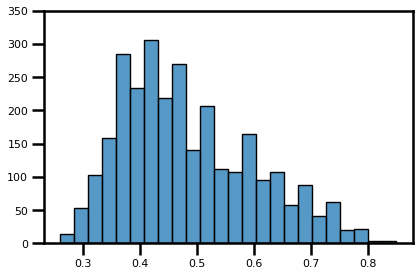

In [6]:
# confidence histogram
print(np.max(metrics1['Y_probas'][-1], axis=1))

sns.set_context("poster", font_scale=0.5)
ax=sns.histplot(data = np.max(metrics1['Y_probas'][-1], axis=1))
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0, 350)
plt.tight_layout()

plt.savefig("../figures/hist_1.jpg")
plt.clf()
ax=sns.histplot(data = np.max(metrics2['Y_probas'][-1], axis=1))
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0, 350)
plt.tight_layout()
plt.savefig("../figures/hist_2.jpg")


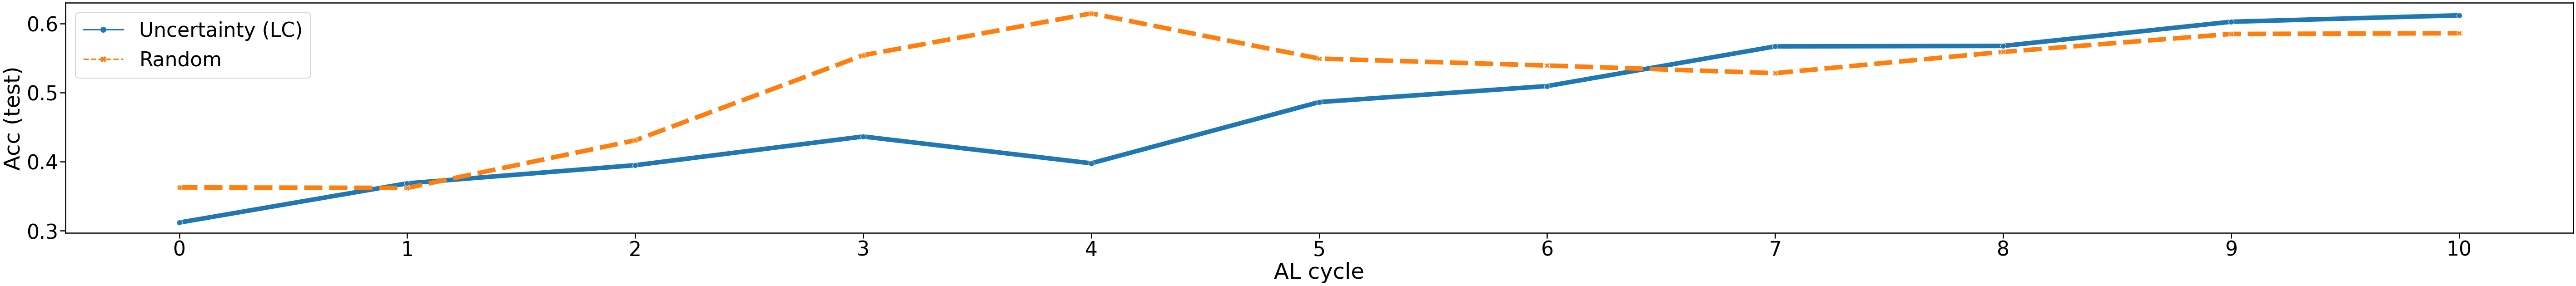

In [7]:
# learning curves
from matplotlib import pyplot
import matplotlib.ticker as ticker
lc_df = pd.DataFrame({'Uncertainty (LC)':metrics1['accs'], 'Random': metrics2['accs']})
sns.set_context("poster", font_scale=2)
fig,ax=pyplot.subplots(figsize=(80,10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
lc_plot = sns.lineplot(data=lc_df, markers=True, linewidth=10)
lc_plot.set(xlabel='AL cycle', ylabel='Acc (test)')
plt.tight_layout()
plt.savefig("../figures/learning_curve.jpg", dpi=150)
plt.show()

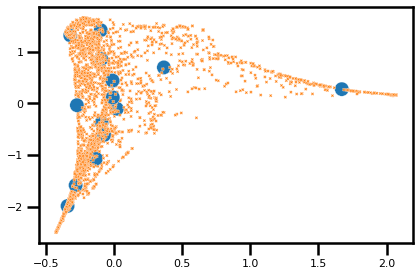

In [8]:
# pca/t-sne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set_context('poster',font_scale=0.5)
pca = PCA(n_components=2)
X_pca = pca.fit(X_train).transform(X_train)
X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=250).fit_transform(X_train)
pca_df1 = pd.DataFrame(X_tsne)
pca_df2 = pd.DataFrame(X_tsne)
pca_df1['L_U'] = ['L' if i in metrics1['L'][-1] else 'U' for i in range(0, len(Y_train))]
pca_df2['L_U'] = ['L' if i in metrics2['L'][-1] else 'U' for i in range(0, len(Y_train))]

ax=sns.scatterplot(data = pca_df1, x=0, y=1, hue="L_U", style='L_U', size="L_U", sizes=(10,200))
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()

plt.tight_layout()
plt.savefig("../figures/tsne_1.jpg")
plt.clf()
ax=sns.scatterplot(data = pca_df2, x=0, y=1, hue="L_U", style='L_U', size="L_U", sizes=(10,200))
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()


plt.savefig("../figures/tsne_2.jpg")
plt.tight_layout()

(3, 140)
(3, 140)
(3, 140)


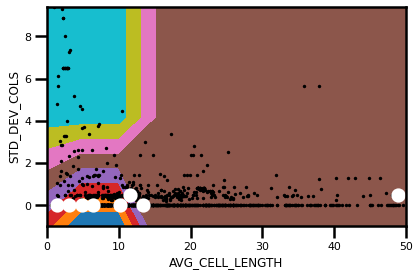

(3, 140)
(3, 140)
(3, 140)


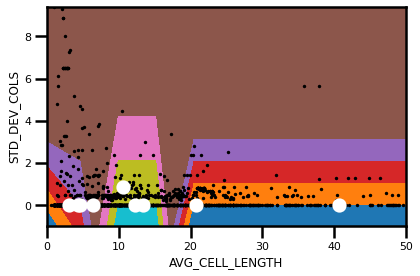

In [9]:
# surface plots
import math

sns.set_context('poster',font_scale=0.5)
def surface_plot(metrics, feature_0, feature_1):
    plot_step = 5.2

    plot_colors = "ryb"
    feature_0_title = df.keys()[feature_0]
    feature_1_title = df.keys()[feature_1]

    X = X_train[metrics['U'][-1]][:, [feature_0,feature_1]]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    print(np.shape(xx))
    print(np.shape(yy))
    rf = RandomForestClassifier()
    rf.fit(X_train[metrics['L'][-1]][:, [feature_0,feature_1]], Y_train[metrics['L'][-1]])
    
    Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    print(np.shape(Z))
    #print(Z)
    cs = plt.contourf(xx, yy, Z, cmap="tab10")

    plt.xlabel(feature_0_title)
    plt.ylabel(feature_1_title)

    # Plot the training points
    for i, color in zip(range(len(np.unique(Y_train))), plot_colors):
        idx = np.where(Y_train[metrics['U'][-1]] == i)
        plt.scatter(x=X[idx, 0], y=X[idx, 1],  color='black', s=2)

    for i, color in zip(range(len(np.unique(Y_train))), plot_colors):
        X = X_train[metrics['L'][-1]][:, [feature_0,feature_1]]
        idx = np.where(Y_train[metrics['L'][-1]] == i)
        plt.scatter(x=X[idx, 0], y=X[idx, 1],  marker='o', color='white', s=150)
    plt.xlim(0, 50)
    return sns

surface_plot(metrics1, 1,5)
plt.tight_layout()
plt.savefig("../figures/surface_1.jpg")
plt.show()
plt.clf()
surface_plot(metrics2, 1,5)
plt.tight_layout()
plt.savefig("../figures/surface_2.jpg")

In [10]:
# data map
def plot_data_map(metrics):
    print(np.shape(metrics['Y_probas'][-1]))
    confidences = []
    variablities = []
    correctness = []
    for sample_id in range(0, np.shape(metrics['Y_probas'][-1])[0]):
        max_values = []
        correctnesses =[]
        for al_cycle in range(0, len(metrics['Y_probas'])):
            max_values.append(np.max(metrics['Y_probas'][al_cycle][sample_id]))
            Y_pred = np.argmax(metrics['Y_probas'][al_cycle][sample_id])
            Y_true = Y_train[sample_id]
            if Y_pred == Y_true:
                correctnesses.append(1)
            else:
                correctnesses.append(0)
        confidences.append(np.mean(max_values))
        variablities.append(np.std(max_values))
        correctness.append(np.sum(correctnesses)/len(metrics['Y_probas']))
        
       
    #print(confidences)
    #print(variablities)
    #print(correctness)
    #exit(-1)

    cartography = pd.DataFrame({
        'variability':variablities,
        'confidence':confidences,
        'correctness':correctness,
    })
    sns.set_context('poster',font_scale=0.5)

    #sns.set(style="whitegrid", context="paper", rc={'figure.figsize': (8, 8)}, font_scale=1.6)
    ax = sns.scatterplot(x=cartography["variability"],
                            y=cartography["confidence"],
                            hue=cartography["correctness"],
                            style=cartography["correctness"],
                            palette=sns.diverging_palette(260, 15, n=13, sep=10, center="dark"))

    # For annotating the regions uncomment the commented lines below

    # bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    # func_annotate = lambda text, xyc, bbc: ax.annotate(text,
    #                                                    xy=xyc,
    #                                                    xycoords="axes fraction",
    #                                                    fontsize=15,
    #                                                    color='black',
    #                                                    va="center",
    #                                                    ha="center",
    #                                                    rotation=350,
    #                                                    bbox=bb(bbc))
    # an1 = func_annotate("ambiguous", xyc=(0.7, 0.5), bbc='black')
    # an2 = func_annotate("easy-to-learn", xyc=(0.3, 0.8), bbc='r')
    # an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.20), bbc='b')

    #ax.legend(fancybox=True, shadow=True, ncol=1)
    ax.get_legend().remove()
    #ax.legend(None)
    ax.set(xlabel="variability", ylabel="confidence")
    #ax.get_legend().set_title("correct.")
    plt.tight_layout()

    #plt.savefig(f"{os.getenv('PLOT_PATH')}{args.task}/{args.task}_results_{args.initial_size}.pdf", dpi=300)
plot_data_map(metrics1)
plt.savefig("../figures/datamap_1.jpg")

plt.show()
plt.clf()
plot_data_map(metrics2)
plt.savefig("../figures/datamap_2.jpg")


(2874, 4)


ValueError: The palette list has the wrong number of colors.